In [1]:
"""CVAE on MNIST
"""
import argparse
import os

import chainer
import pickle
import matplotlib.pyplot as plt
from chainer import training
from chainer.training import extensions
from PIL import Image, ImageDraw
import numpy as np
import cv2

import net 
import make_random_mnist
import make_random_selfdata
from chainer import serializers
%matplotlib inline

In [2]:
'''
img = '../images/inu.png'
dataset = make_random_selfdata.MakeRandomSelfdata(img)    
test = dataset.get_random_dataset_with_one_hot_vector_2d(2)

#print(len(test[0][0])) # 28*28
#print(len(test[0][1])) # cropできる領域の面積 one hot vec 3277

def make_gentle_onehot_vec(hotvec):
    g_hotvec = hotvec.copy()
    deviation = 20
    random_nun = 5000
    hotvec_l = hotvec.tolist()
    average = hotvec_l.index(1)
    g_hotvec[average] = 0
    rand_n = np.random.normal(average, deviation, random_nun)
    for n in range(random_nun):
        index = rand_n[n].astype('int32')
        if(index<0 or len(hotvec_l)<=index):
            continue
        g_hotvec[index] = g_hotvec[index] + 1
    ret = g_hotvec/max(g_hotvec)
    return ret

g_hotvec = make_gentle_onehot_vec(test[0][1])
print(g_hotvec)
plt.plot(g_hotvec)
plt.bar(range(len(g_hotvec)), g_hotvec)
hotvec_l = test[0][1].tolist()
#plt.xlim([hotvec_l.index(1)-20, hotvec_l.index(1)+20])
ave = 8
deviation = 10
random_nun = 10000
rand_n = np.random.normal(ave, deviation, random_nun)
rand_n = rand_n.astype('int32')

plt.bar(rand_n,range())#,bins=100)
#plt.xlim([ave-10,ave+10])
plt.show()
'''

a = np.array([0,1,2,3,4,5,6,7,8,9])
print(type(a))
b = a[:3]
print(b)
def separate_context(context, start, stop):
    print(type(context))
    print('context shape', context.shape)
    img = context[start:stop]
    print('image shape', img.shape)
    label = context[stop:-1]
    print('label shpape', label.shape)
    return img, label
mae, ushio = separate_context(a, 0, 4)

<class 'numpy.ndarray'>
[0 1 2]
<class 'numpy.ndarray'>
context shape (10,)
image shape (4,)
label shpape (5,)


In [3]:
# Visualize the results
def save_images(x, filename,cols=3,rows=3):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(cols, rows, figsize=(9, 9), dpi=100, edgecolor='coral', linewidth=2)
    for ai, xi in zip(ax.ravel(), x):
        ai.imshow(xi.reshape(29,113))
    ai.set_title(filename)
    fig.savefig(filename)
    
def save_onehotvec(x):
    plt.plot(x)
    plt.show()
    
def trainMyModel(model, x_train, x_test, options):
    if options.test:
        x_train, _ = chainer.datasets.split_dataset(x_train, 100)
        x_test, _ = chainer.datasets.split_dataset(x_test, 100)
    train_iter = chainer.iterators.SerialIterator(x_train, options.batchsize)
    test_iter = chainer.iterators.SerialIterator(x_test, options.batchsize,repeat=False, shuffle=False)
    
    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Initialize
    if options.initmodel:
        chainer.serializers.load_npz(options.initmodel, model)

    # Set up an updater. StandardUpdater can explicitly specify a loss function
    # used in the training with 'loss_func' option
    updater = training.updaters.StandardUpdater(train_iter, optimizer,device=options.gpu, loss_func=model.get_loss_func())

    trainer = training.Trainer(updater, (options.epoch, 'epoch'), out=options.out)
    trainer.extend(extensions.Evaluator(test_iter, model, device=options.gpu,eval_func=model.get_loss_func(k=10)))
    trainer.extend(extensions.dump_graph('main/loss'))
    trainer.extend(extensions.snapshot(), trigger=(20, 'epoch'))
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/rec_loss', 'validation/main/rec_loss', 'elapsed_time']))
    #trainer.extend(extensions.ProgressBar())

    if options.resume:
        chainer.serializers.load_npz(options.resume, trainer)

    # Run the training
    trainer.run()
    model.to_cpu()
    serializers.save_npz("mymodel_final.npz", model)
    return model

def testMyModel(model, x_test):
    pass

In [4]:
def load_save_random_dataset_withlabel(fname, n):
    dataset = make_random_mnist.MakeRandomMNIST()
    if os.path.exists(fname):
        with open(fname, mode='rb') as f:
            ret = pickle.load(f)
            return ret
    v = dataset.get_random_dataset_with_label(n)
    with open(fname, mode='wb') as f:
        pickle.dump(v, f)
        return v

def dispImage(img_vec):
    #title = 'Label number is ('+ str(label_x) + ',' + str(label_y) + ')' 
    pixels = (img_vec * 256).reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.axis("off")
    #plt.title(title)
    plt.show()

def dispOneHotVec(img, vec, vec_size,vec_ratio):
    t_img = img.copy() # cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    #print(np.where(vec==1))
    hotvec = vec.reshape(vec_size)
    #print(hotvec.shape)
    cx, cy = np.where(hotvec == 1)
    #print(cx, cy)
    conv_img_coord_x = (cy*vec_ratio)+14
    conv_img_coord_y = (cx*vec_ratio)+14
    t_img = cv2.circle(t_img, (conv_img_coord_x,conv_img_coord_y), 1, (255, 0, 0), thickness=-1, lineType=cv2.LINE_8, shift=0)
    t_img = cv2.rectangle(t_img, (conv_img_coord_x-14,conv_img_coord_y-14), 
                          (conv_img_coord_x+14,conv_img_coord_y+14), (255,0,0), thickness=0, lineType=cv2.LINE_8, shift=0)
    fig = plt.figure() # Figureオブジェクトを作成
    ax = fig.add_subplot(1,1,1) # figに属するAxesオブジェクトを作成
    plt.imshow(t_img)
    plt.show()
def dispCropPos(img, data, label_vec_size, vec_ratio, color=(248,169,0)):
    t_img = img.copy()
    for n in range(len(data)):
        im, la = data[n]
        #print(la.shape)
        hotvec = la.reshape(label_vec_size)
        cx, cy = np.where(hotvec == 1)
        conv_img_coord_x = (cy*vec_ratio)+14
        conv_img_coord_y = (cx*vec_ratio)+14
        t_img[conv_img_coord_y, conv_img_coord_x] = color
    return t_img

In [5]:
def chageBrightness(data, label_vec_size):
    data_num = len(data)
    images = np.zeros((data_num, 28*28), dtype=np.float32)  
    labels = np.zeros((data_num, label_vec_size[0]*label_vec_size[1]), dtype=np.float32)  
    for i in range(data_num):
        img, label = data[i]
        rand_gain = np.random.uniform(-0.3, 0.3, (28*28))
        im = img+rand_gain
        # 0 miman
        im = np.where(im > 1, 1, im)
        # 1 izyou
        im = np.where(im < 0, 0, im)
        images[i, :] = im
        labels[i, :] = label
    return chainer.datasets.TupleDataset(images, labels)

def addGomashio(data, label_vec_size):
    size = 1
    data_num = len(data)
    images = np.zeros((data_num, 28*28), dtype=np.float32)  
    labels = np.zeros((data_num, label_vec_size[0]*label_vec_size[1]), dtype=np.float32)  
    for n in range(data_num):
        x = int(np.random.uniform(0,27))
        y = int(np.random.uniform(0,27))
        c = int(np.random.uniform(0,256))
        img, label = data[n]
        img = (img * 256).reshape((28, 28))
        img = cv2.rectangle(img, (x, y),(x+size,y+size), c, -1)
        img = img.flatten()
        images[n, :] = img/256.
        labels[n, :] = label
    return chainer.datasets.TupleDataset(images, labels)

GPU: 0
# dim z: 2
# Minibatch-size: 200
# epoch: 15

113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
113
29
11

TypeError: Invalid dimensions for image data

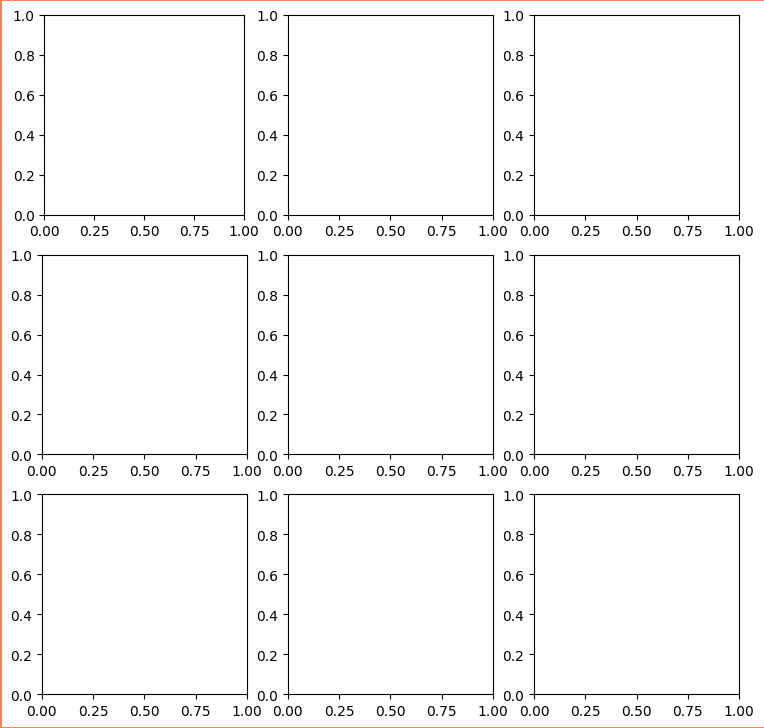

In [6]:
def main():
    global NLABELDIM, NZDIM
    parser = argparse.ArgumentParser(description='Chainer example: VAE')
    parser.add_argument('--initmodel', '-m', default='',
                        help='Initialize the model from given file')
    parser.add_argument('--resume', '-r', default='',
                        help='Resume the optimization from snapshot')
    parser.add_argument('--gpu', '-g', default=-1, type=int,
                        help='GPU ID (negative value indicates CPU)')
    parser.add_argument('--out', '-o', default='result',
                        help='Directory to output the result')
    parser.add_argument('--epoch', '-e', default=15, type=int,
                        help='number of epochs to learn')
    parser.add_argument('--dimz', '-z', default=2, type=int,
                        help='dimention of encoded vector')
    parser.add_argument('--batchsize', '-b', type=int, default=200,
                        help='learning minibatch size')
    parser.add_argument('--test', action='store_true',
                        help='Use tiny datasets for quick tests')
    args = parser.parse_args(args=['-g 0'])

    print('GPU: {}'.format(args.gpu))
    print('# dim z: {}'.format(args.dimz))
    print('# Minibatch-size: {}'.format(args.batchsize))
    print('# epoch: {}'.format(args.epoch))
    print('')

    #img = '../images/chizu_naga.png'
    img = '../images/inu.png'
    dataset = make_random_selfdata.MakeRandomSelfdata(img)    
    global train,test
    train = dataset.get_random_dataset_for_rcvae(3000)
    test = dataset.get_random_dataset_for_rcvae(3000)
    
    # Prepare CVAE model, defined in net.py
    NLABELDIM = len(train[0][1])
    CONTEXTDIM = len(train[0][0])
    print('NLABEL', NLABELDIM)
    print('CONDITION', NLABELDIM)
    print('CONTEXT', CONTEXTDIM)
    NZDIM = args.dimz

    model = net.MyCVAE(CONTEXTDIM, args.dimz, 500, NLABELDIM)
    model = trainMyModel(model,train,test,args)
    
    train_ind = [1, 3, 5, 10, 2, 0, 13, 15, 17]
    xin = np.empty((0, CONTEXTDIM), np.float32)
    xout = np.empty((0, CONTEXTDIM), np.float32)
    for ind in train_ind:
        x, t = train[ind]
        x = np.expand_dims(x, axis=0)
        t = np.expand_dims(t.astype(np.float32), axis=0)
        #t = np.eye(NLABELDIM, dtype=np.float32)[t * NLABELDIM]
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x1 = model(x, np.expand_dims(t, axis=0))
            xin = np.append(xin, x, axis=0)
            xout = np.append(xout, x1.data, axis=0)
    save_images(xin, os.path.join(args.out, 'train'))
    save_images(xout, os.path.join(args.out, 'train_reconstructed'))

    test_ind = [3, 2, 1, 18, 4, 8, 11, 17, 61]
    xin = np.empty((0, CONTEXTDIM), np.float32)
    xout = np.empty((0, CONTEXTDIM), np.float32)
    for ind in test_ind:
        x, t = test[ind]
        x = np.expand_dims(x, axis=0)
        t = np.expand_dims(t.astype(np.float32), axis=0)
        #t = np.eye(NLABELDIM, dtype=np.float32)[t * NLABELDIM]
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            x1 = model(x, np.expand_dims(t, axis=0))
            xin = np.append(xin, x, axis=0)
            xout = np.append(xout, x1.data, axis=0)

    save_images(xin, os.path.join(args.out, 'test'))
    save_images(xout, os.path.join(args.out, 'test_reconstructed'))
if __name__ == '__main__':
    main()

# conditionで画像を生成するための共通の部分

In [ ]:
NZDIM = 2
NLABELDIM = len(train[0][1])
CONTEXTDIM = len(train[0][0])
model = net.MyCVAE(CONTEXTDIM, NZDIM, 500, NLABELDIM)
serializers.load_npz("mymodel_final.npz", model)
# draw images from randomly sampled z
#z = chainer.Variable(np.random.normal(0, 1, (10, NZDIM)).astype(np.float32))
z = chainer.Variable(np.zeros((10, NZDIM), dtype=np.float32))

# 28ｘ28の画像が2x5で並んでる訓練画像用

In [ ]:
#'''
img = '../images/inu.png'
t_img = cv2.imread(img)
dataset = make_random_selfdata.MakeRandomSelfdata(img)
onehot_size = dataset.getOnehotSize()
labels = np.zeros((10, onehot_size[0]*onehot_size[1]), dtype=np.float32)       # one hot vector
images = np.zeros((10, 28*28), dtype=np.float32)       # condition

#'''
###########画像の中心を見る用#############　
for r in range(2):
    for c in range(5):
        l = dataset.getLabel(28*c+14, 28*r+14)
        i = dataset.getImage(l[0], l[1])
        dispOneHotVec(t_img, l,dataset.getOnehotSize(),dataset.onehot_ratio)
        labels[r*5+c, :] = l
        images[r*5+c, :] = np.reshape(i, 28*28)
values = images
x1 = model.decode(z, np.expand_dims(values, axis=1))
save_onehotvec(x1.data[8])

#'''

#'''###########細かいとこを見る用#############　

s = 100
for i in range(s,s+10):
    l = dataset.getLabel(i+14, 0+14)
    dispOneHotVec(t_img, l,dataset.getOnehotSize(),dataset.onehot_ratio)
    labels[i-s, :] = l
values = labels
x = model.decode(z, np.expand_dims(values, axis=1))
save_images(x.data, 'sampled',2, 5)
#'''

#t_test = np.zeros((10,28*28)), labels
t_test = chainer.datasets.TupleDataset(np.zeros((10,28*28)), labels)
print(labels.shape)
print(np.zeros((10,28*28)).shape)
print(len(labels))
# 訓練データとテストデータ表示するところ

image = cv2.imread(img)
h,w,_ = image.shape[:3]
disped_train_pos = np.zeros((w, h))
disped_train_pos = dispCropPos(cv2.imread(img), t_test, dataset.getOnehotSize(),dataset.onehot_ratio)
disped_test_pos = dispCropPos(disped_train_pos, train, dataset.getOnehotSize(),dataset.onehot_ratio, (167,81,168))
fig = plt.figure() # Figureオブジェクトを作成
plt.imshow(disped_test_pos)
plt.show()